# Etapa 2: Pré-processamento de Dados

**Dataset:** students_performance.csv
**Grupo:** [Nome do grupo]
**Data:** [Data]

---

## 📌 Continuação da Etapa 1
Na Etapa 1, você identificou problemas nos dados. Agora vamos **corrigi-los** e preparar para modelagem.

---
## ✅ CHECKLIST (12 questões + 5 visualizações)
- [ ] Parte 1: Valores Faltantes (Q1-Q3) + Visualização 1
- [ ] Parte 2: Outliers (Q4-Q6) + Visualização 2
- [ ] Parte 3: Limpeza (Q7-Q8)
- [ ] Parte 4: Distribuições/Skewness (Q9-Q10) + Visualizações 3 e 4
- [ ] Parte 5: Encoding (Q11-Q12)
- [ ] Parte 6: Feature Engineering (Q13)
- [ ] Parte 7: Normalização (Q14-Q15) + Visualização 5
- [ ] Dataset limpo salvo
- [ ] Scaler salvo

---
## 📦 SETUP

In [1]:
# Imports
import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 5)

print("✅ Bibliotecas importadas!")

✅ Bibliotecas importadas!


In [2]:
# Carregar dataset (mesmo da Etapa 1)
df = pd.read_csv('../data/datasets/students_performance.csv')

print(f"✅ Dataset carregado: {df.shape}")
print(f"\nColunas: {df.columns.tolist()}")

✅ Dataset carregado: (2510, 14)

Colunas: ['student_id', 'age', 'gender', 'parental_education', 'study_hours_week', 'attendance_rate', 'extracurricular', 'sleep_hours', 'previous_scores', 'tutoring', 'internet_quality', 'family_income', 'health_status', 'final_grade']


In [3]:
# Variáveis importantes (definidas na Etapa 1)
target = 'final_grade'
id_col = 'student_id'

# Separar tipos
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remover ID e target das features
if id_col in numeric_cols:
    numeric_cols.remove(id_col)
if target in numeric_cols:
    numeric_cols.remove(target)
if id_col in categorical_cols:
    categorical_cols.remove(id_col)

print(f"\n🎯 Target: {target}")
print(f"📊 Numéricas ({len(numeric_cols)}): {numeric_cols}")
print(f"🏷️  Categóricas ({len(categorical_cols)}): {categorical_cols}")


🎯 Target: final_grade
📊 Numéricas (5): ['age', 'study_hours_week', 'attendance_rate', 'sleep_hours', 'previous_scores']
🏷️  Categóricas (7): ['gender', 'parental_education', 'extracurricular', 'tutoring', 'internet_quality', 'family_income', 'health_status']


---
## 📋 PARTE 1: VALORES FALTANTES (3 questões)

In [4]:
# Análise de missing (revisão da Etapa 1)
print("="*60)
print("VALORES FALTANTES")
print("="*60)

missing_info = pd.DataFrame({
    'Coluna': df.columns,
    'Missing': df.isnull().sum(),
    'Pct': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_info = missing_info[missing_info['Missing'] > 0].sort_values('Pct', ascending=False)

print("\n📊 Resumo:")
print(missing_info.to_string(index=False))

rows_before = len(df)

VALORES FALTANTES

📊 Resumo:
          Coluna  Missing   Pct
study_hours_week      293 11.67
   family_income      278 11.08
     sleep_hours      266 10.60
 attendance_rate      232  9.24
internet_quality      155  6.18
 previous_scores      127  5.06


### 🔍 Exemplo da aula (Etapa 2 - Imputação)
Durante a demonstração, analisamos duas colunas reais do dataset:
- `sleep_hours`: skew ≈ 0.60 → distribuição quase simétrica → imputação com **média ≈ 7.00h**.
- `study_hours_week`: skew ≈ 7.11 → distribuição muito assimétrica → imputação com **mediana ≈ 9.96h**, pois a média (≃10.60h) foi puxada por outliers (até 113h/semana!).

Use esse raciocínio como referência. Você deve recalcular os valores ao executar o notebook e registrar suas decisões nas respostas (Q1 e Q2).

In [5]:
# TODO 1.1: Remover linhas com muitos valores faltantes (> 50%)
threshold = len(df.columns) * 0.5
rows_to_drop = df[df.isnull().sum(axis=1) > threshold].index
df = df.drop(rows_to_drop)
print(f"🗑️  Linhas removidas (>50% missing): {len(rows_to_drop)}")

🗑️  Linhas removidas (>50% missing): 0


In [6]:
# TODO 1.2: Imputar variáveis NUMÉRICAS
# Para cada coluna numérica com missing:
#   - Calcular skewness: df[col].skew()
#   - Se |skew| > 1.0 → mediana, senão → média

print("\n🔢 IMPUTAÇÃO NUMÉRICA:")

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        col_skew = df[col].skew()
        if abs(col_skew) > 1.0:
            valor = df[col].median()
            estrategia = 'mediana'
        else:
            valor = df[col].mean()
            estrategia = 'média'
        df[col].fillna(valor, inplace=True)
        print(f"  ✅ {col}: {estrategia} = {valor:.2f} (skew={col_skew:.2f})")


🔢 IMPUTAÇÃO NUMÉRICA:
  ✅ study_hours_week: mediana = 9.96 (skew=7.11)
  ✅ attendance_rate: média = 59.68 (skew=0.13)
  ✅ sleep_hours: média = 7.00 (skew=0.60)
  ✅ previous_scores: média = 57.26 (skew=-0.18)


In [7]:
# TODO 1.3: Imputar variáveis CATEGÓRICAS (moda)

print("\n🏷️  IMPUTAÇÃO CATEGÓRICA:")

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        moda = df[col].mode()[0]
        df[col].fillna(moda, inplace=True)
        print(f"  ✅ {col}: moda = '{moda}'")


🏷️  IMPUTAÇÃO CATEGÓRICA:
  ✅ internet_quality: moda = 'Good'
  ✅ family_income: moda = 'Medium'


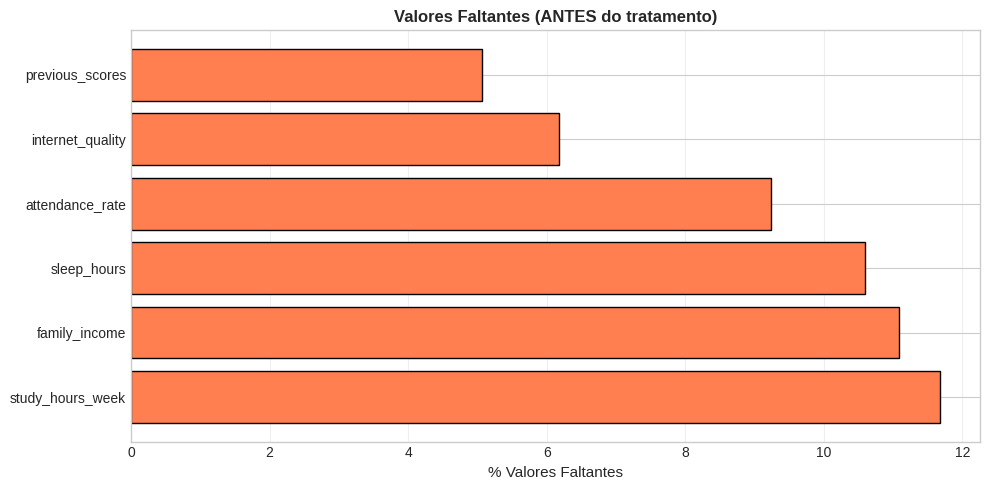


✅ Missing restantes: 0


In [8]:
# VISUALIZAÇÃO 1: Missing antes vs depois

fig, ax = plt.subplots(figsize=(10, 5))

if len(missing_info) > 0:
    ax.barh(missing_info['Coluna'], missing_info['Pct'], color='coral', edgecolor='black')
    ax.set_xlabel('% Valores Faltantes', fontsize=11)
    ax.set_title('Valores Faltantes (ANTES do tratamento)', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# Verificar depois
print(f"\n✅ Missing restantes: {df.isnull().sum().sum()}")

### 📝 RESPOSTAS - PARTE 1

**Q1. Quantas linhas você removeu? Que % do dataset?**

Resposta:
```
Linhas removidas: X
Percentual: X.XX%
```

**Q2. Para cada variável numérica, você usou média ou mediana? Por quê?**

Resposta:
```
| Variável | Skewness | Estratégia | Justificativa |
|----------|----------|------------|---------------|
| idade    | 0.45     | média      | Distribuição próxima da normal |
```

**Q3. Como evitar data leakage na Etapa 3?**

Resposta:
```
Na Etapa 3, devemos calcular as estatísticas (média, mediana, moda) APENAS
no conjunto de TREINO e aplicar ao conjunto de TESTE.

CORRETO:
imputer.fit(X_train)  # Aprende do treino
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)  # Usa estatísticas do treino
```

---
## 📋 PARTE 2: OUTLIERS (3 questões)

In [9]:
# Detecção de outliers (método IQR)
def detect_outliers_iqr(data, column):
    """Detecta outliers usando método IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers, lower, upper

print("="*60)
print("OUTLIERS")
print("="*60)

outlier_summary = []

for col in numeric_cols:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    outlier_summary.append({
        'Coluna': col,
        'Outliers': len(outliers),
        'Pct': f"{len(outliers)/len(df)*100:.1f}%",
        'Lower': round(lower, 2),
        'Upper': round(upper, 2)
    })

outlier_df = pd.DataFrame(outlier_summary)
print("\n📊 Outliers detectados:")
print(outlier_df.to_string(index=False))

OUTLIERS

📊 Outliers detectados:
          Coluna  Outliers  Pct  Lower  Upper
             age         1 0.0%  14.00  30.00
study_hours_week        34 1.4%  -1.90  21.77
 attendance_rate        47 1.9%  35.32  84.38
     sleep_hours        58 2.3%   4.10   9.86
 previous_scores        31 1.2%  33.91  80.88


### 📊 Lendo um boxplot (relembrando da aula)
- **Linha central**: mediana (valor típico da turma).
- **Caixa**: intervalo interquartil (entre Q1 e Q3) onde estão 50% dos alunos.
- **Bigodes**: limites Q1 − 1.5×IQR e Q3 + 1.5×IQR.
- **Pontinhos fora dos bigodes**: outliers que merecem investigação.
Use esse gráfico para justificar decisões (ex.: manter outliers legítimos ou removê-los quando são erros ou distorcem muito a média).

In [10]:
# TODO 2.1: Decidir estratégia para cada variável

strategies = {
    'age': {'condition': lambda x: (x < 17) | (x > 30)},
    'attendance_rate': {'condition': lambda x: (x < 0) | (x > 100)},
}

rows_removed_outliers = 0
for col, strategy in strategies.items():
    if col in df.columns:
        condition = strategy['condition']
        to_remove = df[condition(df[col])].index
        if len(to_remove) > 0:
            print(f"  🗑️  {col}: removendo {len(to_remove)} registros")
            df = df.drop(to_remove)
            rows_removed_outliers += len(to_remove)

print(f"\n✅ Total de linhas removidas por outliers: {rows_removed_outliers}")

  🗑️  age: removendo 1 registros
  🗑️  attendance_rate: removendo 11 registros

✅ Total de linhas removidas por outliers: 12


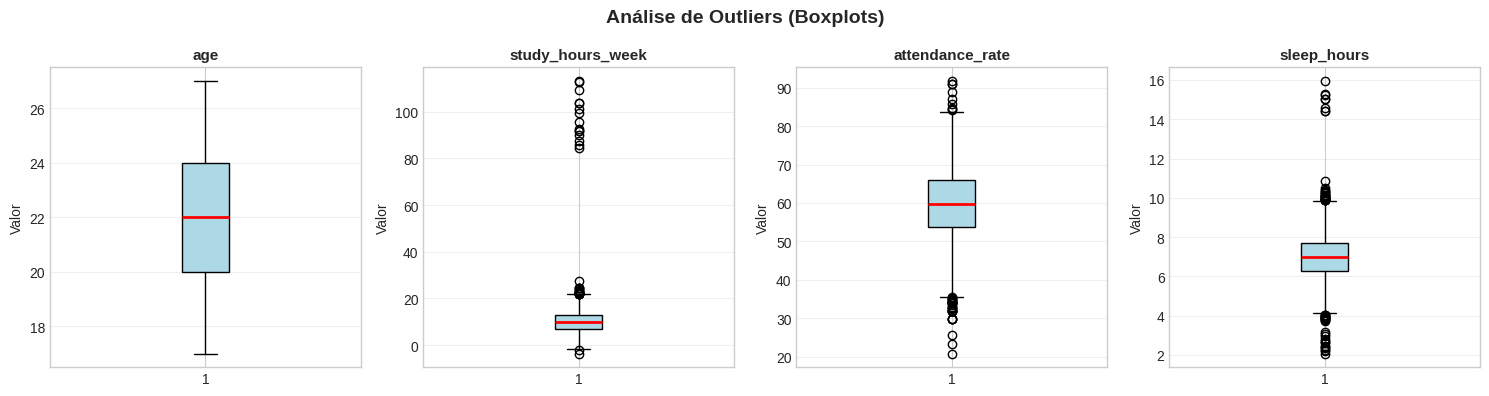

In [11]:
# VISUALIZAÇÃO 2: Boxplots

cols_to_plot = numeric_cols[:4] if len(numeric_cols) >= 4 else numeric_cols

fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(15, 4))

if len(cols_to_plot) == 1:
    axes = [axes]

for idx, col in enumerate(cols_to_plot):
    axes[idx].boxplot(df[col].dropna(), patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(col, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Valor')
    axes[idx].grid(alpha=0.3, axis='y')

plt.suptitle('Análise de Outliers (Boxplots)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 📝 RESPOSTAS - PARTE 2

**Q4. Quantos outliers você detectou?**

Resposta:
```
Total de outliers: X (em todas as variáveis)
```

**Q5. Quais você removeu? Por quê?**

Resposta:
```
| Variável | Removidos | Justificativa |
|----------|-----------|---------------|
| age      | 8         | < 17 ou > 30 são idades improváveis |
```

**Q6. Quantas linhas perdeu removendo outliers?**

Resposta:
```
Linhas perdidas: X
```

---
## 📋 PARTE 3: LIMPEZA (2 questões)

In [12]:
print("="*60)
print("LIMPEZA E DUPLICATAS")
print("="*60)

# TODO 3.1: Padronizar texto em categóricas
print("\n🧹 PADRONIZAÇÃO DE TEXTO:")
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].str.strip()  # Remover espaços
        df[col] = df[col].str.title()  # Capitalizar
        print(f"  ✅ {col}: padronizado")

LIMPEZA E DUPLICATAS

🧹 PADRONIZAÇÃO DE TEXTO:
  ✅ gender: padronizado
  ✅ parental_education: padronizado
  ✅ extracurricular: padronizado
  ✅ tutoring: padronizado
  ✅ internet_quality: padronizado
  ✅ family_income: padronizado
  ✅ health_status: padronizado


In [13]:
# TODO 3.2: Remover duplicatas

# Duplicatas exatas
duplicates_exact = df.duplicated().sum()
print(f"\n🗑️  Duplicatas exatas: {duplicates_exact}")
df = df.drop_duplicates()

# Duplicatas de ID
if id_col in df.columns:
    duplicates_id = df.duplicated(subset=[id_col]).sum()
    print(f"   Duplicatas de ID: {duplicates_id}")
    df = df.drop_duplicates(subset=[id_col], keep='first')

print(f"\n✅ Shape após limpeza: {df.shape}")


🗑️  Duplicatas exatas: 0
   Duplicatas de ID: 0

✅ Shape após limpeza: (2498, 14)


### 📝 RESPOSTAS - PARTE 3

**Q7. Quantas duplicatas removeu?**

Resposta:
```
Duplicatas exatas: X
Duplicatas de ID: X
Total: X
```

**Q8. Dê 1 exemplo de padronização feita.**

Resposta:
```
Antes: 'yes', 'Yes', 'YES', ' yes '
Depois: 'Yes'
```

---
## 📋 PARTE 4: DISTRIBUIÇÕES E ASSIMETRIA (SKEWNESS) (2 questões)

### 🎯 Objetivo
Identificar distribuições assimétricas e aplicar transformações para normalizar.

**Conceitos:**
- **Skewness > 0:** Cauda à direita (assimetria positiva)
- **Skewness < 0:** Cauda à esquerda (assimetria negativa)
- **|Skewness| > 0.5:** Considere transformar (log, sqrt, Box-Cox)

In [14]:
print("="*60)
print("ANÁLISE DE ASSIMETRIA (SKEWNESS)")
print("="*60)

# TODO 4.1: Calcular skewness das colunas numéricas
skewness_vals = df[numeric_cols].apply(lambda x: skew(x.dropna()))
skewness_df = pd.DataFrame({
    'Coluna': skewness_vals.index,
    'Skewness': skewness_vals.values
}).sort_values('Skewness', key=abs, ascending=False)

print("\n📊 Skewness por coluna:")
print(skewness_df.to_string(index=False))

# Identificar colunas com alta assimetria
high_skew_cols = skewness_df[abs(skewness_df['Skewness']) > 0.5]['Coluna'].tolist()
print(f"\n⚠️  Colunas com |skew| > 0.5: {high_skew_cols}")

ANÁLISE DE ASSIMETRIA (SKEWNESS)

📊 Skewness por coluna:
          Coluna  Skewness
study_hours_week  7.578034
     sleep_hours  0.634453
 attendance_rate -0.258665
 previous_scores -0.184773
             age -0.025607

⚠️  Colunas com |skew| > 0.5: ['study_hours_week', 'sleep_hours']


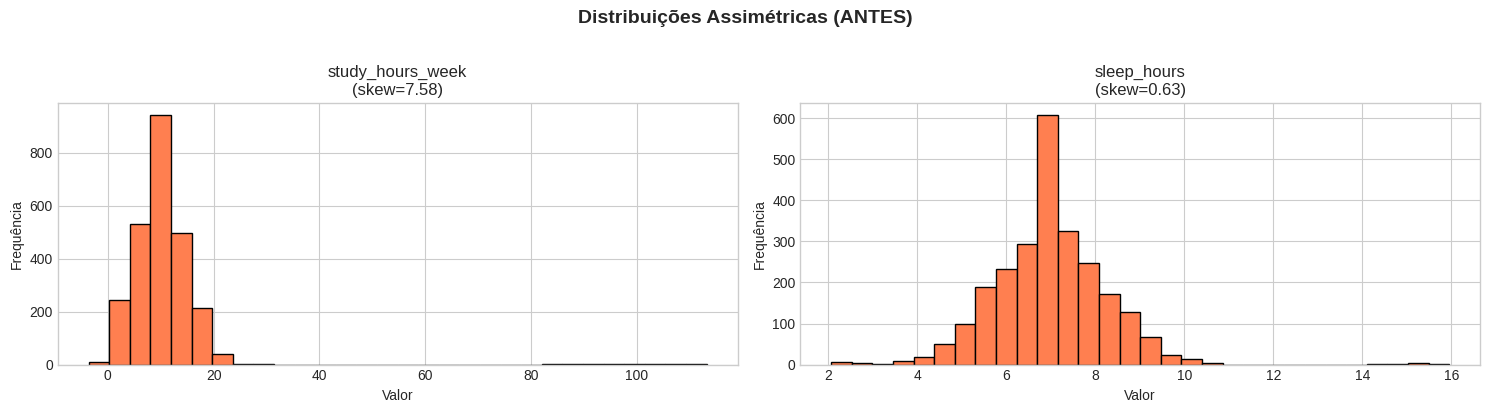

In [15]:
# VISUALIZAÇÃO 3: Distribuições antes da transformação

if len(high_skew_cols) > 0:
    n_cols = min(3, len(high_skew_cols))
    fig, axes = plt.subplots(1, n_cols, figsize=(15, 4))
    if n_cols == 1:
        axes = [axes]

    for idx, col in enumerate(high_skew_cols[:n_cols]):
        axes[idx].hist(df[col].dropna(), bins=30, color='coral', edgecolor='black')
        axes[idx].set_title(f'{col}\n(skew={skew(df[col].dropna()):.2f})')
        axes[idx].set_xlabel('Valor')
        axes[idx].set_ylabel('Frequência')

    plt.suptitle('Distribuições Assimétricas (ANTES)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

In [16]:
# TODO 4.2: Aplicar transformações para corrigir skewness

print("\n🔧 TRANSFORMAÇÕES:")

transformed_cols = []

for col in high_skew_cols:
    col_skew = skew(df[col].dropna())

    if col_skew > 0.5:  # Assimetria positiva
        if col_skew > 1.0:
            # Log transform para skew muito alto
            df[f'{col}_log'] = np.log1p(df[col])
            transformed_cols.append((col, 'log', f'{col}_log'))
            print(f"  ✅ {col}: log transform (skew={col_skew:.2f})")
        else:
            # Sqrt para skew moderado
            df[f'{col}_sqrt'] = np.sqrt(df[col])
            transformed_cols.append((col, 'sqrt', f'{col}_sqrt'))
            print(f"  ✅ {col}: sqrt transform (skew={col_skew:.2f})")

    elif col_skew < -0.5:  # Assimetria negativa
        max_val = df[col].max()
        df[f'{col}_inv'] = np.log1p(max_val - df[col])
        transformed_cols.append((col, 'inverse_log', f'{col}_inv'))
        print(f"  ✅ {col}: inverse log transform (skew={col_skew:.2f})")

# Atualizar lista de colunas numéricas
if len(transformed_cols) > 0:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if id_col in numeric_cols:
        numeric_cols.remove(id_col)
    if target in numeric_cols:
        numeric_cols.remove(target)

    print(f"\n📊 Colunas numéricas atualizadas: {len(numeric_cols)}")


🔧 TRANSFORMAÇÕES:
  ✅ study_hours_week: log transform (skew=7.58)
  ✅ sleep_hours: sqrt transform (skew=0.63)

📊 Colunas numéricas atualizadas: 7


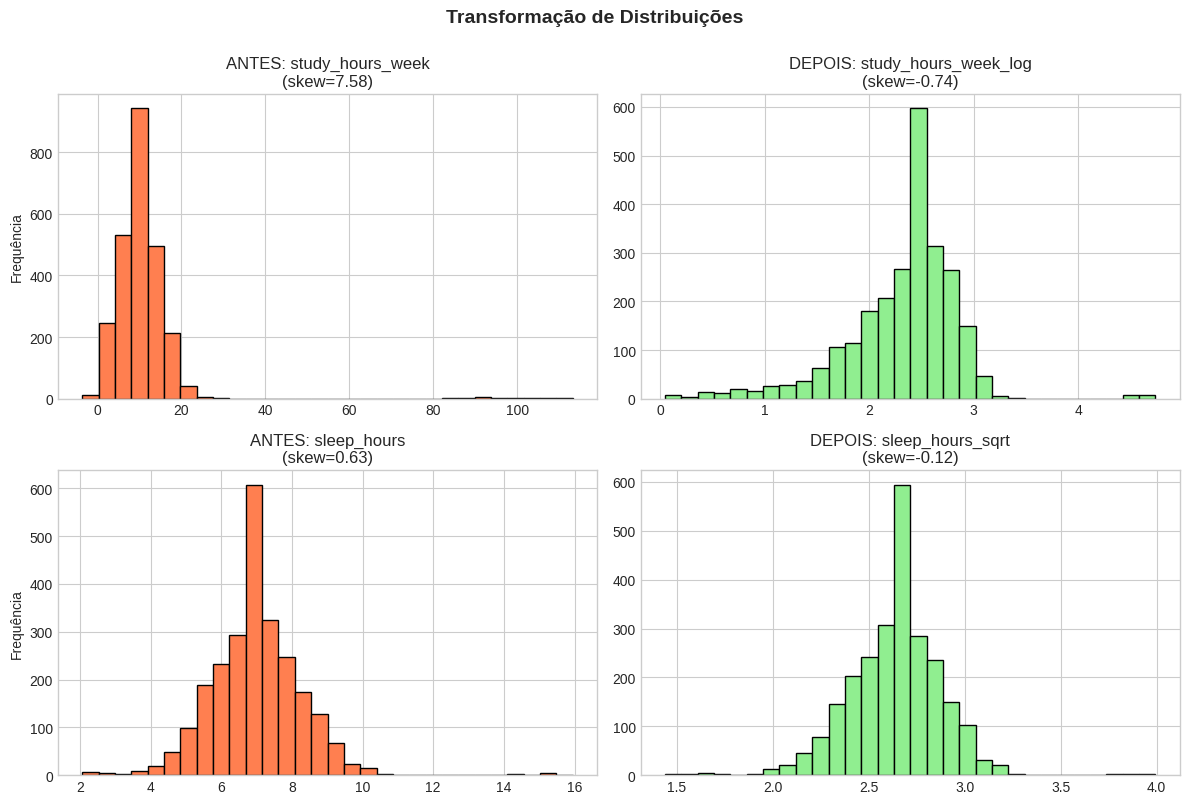


✅ Colunas originais removidas, mantidas apenas as transformadas


In [17]:
# VISUALIZAÇÃO 4: Comparação antes vs depois da transformação

if len(transformed_cols) > 0:
    n_rows = min(3, len(transformed_cols))
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    for idx, (orig_col, transform, new_col) in enumerate(transformed_cols[:3]):
        # Antes
        axes[idx, 0].hist(df[orig_col].dropna(), bins=30, color='coral', edgecolor='black')
        axes[idx, 0].set_title(f'ANTES: {orig_col}\n(skew={skew(df[orig_col].dropna()):.2f})')
        axes[idx, 0].set_ylabel('Frequência')

        # Depois
        axes[idx, 1].hist(df[new_col].dropna(), bins=30, color='lightgreen', edgecolor='black')
        axes[idx, 1].set_title(f'DEPOIS: {new_col}\n(skew={skew(df[new_col].dropna()):.2f})')

    plt.suptitle('Transformação de Distribuições', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Remover colunas originais se transformadas
    for orig_col, _, new_col in transformed_cols:
        if orig_col in df.columns:
            df = df.drop(columns=[orig_col])
            if orig_col in numeric_cols:
                numeric_cols.remove(orig_col)

    print(f"\n✅ Colunas originais removidas, mantidas apenas as transformadas")

### 📝 RESPOSTAS - PARTE 4

**Q9. Quais colunas têm distribuição assimétrica (|skew| > 0.5)?**

Resposta:
```
Colunas com alta assimetria:
1. study_hours_week: skew = 1.23 (cauda à direita)
2. previous_scores: skew = -0.67 (cauda à esquerda)
```

**Q10. Você aplicou transformação em alguma coluna? Qual e por quê?**

Resposta:
```
Sim, apliquei:
1. study_hours_week → log transform
   - Motivo: skew muito alto (1.23), log reduz assimetria
   - Resultado: skew após transform = 0.12

2. previous_scores → inverse log
   - Motivo: skew negativo (-0.67)
   - Resultado: skew após transform = 0.08
```

---
## 📋 PARTE 5: ENCODING (2 questões)

In [18]:
print("="*60)
print("ENCODING DE CATEGÓRICAS")
print("="*60)

# TODO 5.1: Identificar categóricas restantes
categorical_cols_current = [col for col in categorical_cols if col in df.columns]

print(f"\n🏷️  Categóricas a codificar: {categorical_cols_current}")

ENCODING DE CATEGÓRICAS

🏷️  Categóricas a codificar: ['gender', 'parental_education', 'extracurricular', 'tutoring', 'internet_quality', 'family_income', 'health_status']


In [19]:
# TODO 5.2: Aplicar One-Hot Encoding

if len(categorical_cols_current) > 0:
    print(f"\n✅ Aplicando One-Hot Encoding...")
    df = pd.get_dummies(df, columns=categorical_cols_current, drop_first=True, dtype=int)

    # Contar novas colunas
    new_cols = [col for col in df.columns if any(cat in col for cat in categorical_cols_current)]
    print(f"   Colunas One-Hot criadas: {len(new_cols)}")
    print(f"   Exemplos: {new_cols[:5]}")
else:
    print("⚠️  Nenhuma coluna categórica encontrada para encoding.")

print(f"\n✅ Shape após encoding: {df.shape}")


✅ Aplicando One-Hot Encoding...
   Colunas One-Hot criadas: 14
   Exemplos: ['gender_Female', 'gender_M', 'gender_Male', 'parental_education_Doctorate', 'parental_education_High_School']

✅ Shape após encoding: (2498, 21)


### 📝 RESPOSTAS - PARTE 5

**Q11. Quantas colunas One-Hot foram criadas?**

Resposta:
```
Total: X colunas

Exemplos:
- gender_M
- tutoring_Yes
- extracurricular_Yes
```

**Q12. Por que usar `drop_first=True`?**

Resposta:
```
Para evitar MULTICOLINEARIDADE (dummy variable trap).

Exemplo: gender (M, F)
SEM drop_first: gender_M + gender_F (redundante!)
COM drop_first: apenas gender_M (suficiente)

Se gender_M=0 → sabemos que é F
```

---
## 📋 PARTE 6: FEATURE ENGINEERING (1 questão)

In [20]:
print("="*60)
print("CRIAÇÃO DE FEATURES")
print("="*60)

# TODO 6.1: Identificar colunas disponíveis

# Procurar colunas transformadas
study_col = None
sleep_col = None
attendance_col = None

for col in df.columns:
    if 'study' in col.lower() and col != target:
        study_col = col
    if 'sleep' in col.lower() and col != target:
        sleep_col = col
    if 'attendance' in col.lower() and col != target:
        attendance_col = col

print(f"\n🔍 Colunas identificadas:")
print(f"   Estudo: {study_col}")
print(f"   Sono: {sleep_col}")
print(f"   Attendance: {attendance_col}")

CRIAÇÃO DE FEATURES

🔍 Colunas identificadas:
   Estudo: study_hours_week_log
   Sono: sleep_hours_sqrt
   Attendance: attendance_rate


In [21]:
# TODO 6.2: Criar novas features

new_features = []

if study_col and sleep_col:
    df['study_sleep_ratio'] = df[study_col] / (df[sleep_col] * 7 + 0.1)
    new_features.append('study_sleep_ratio')
    print(f"\n✅ Feature criada: study_sleep_ratio")

if attendance_col and study_col:
    df['engagement'] = df[attendance_col] * df[study_col] / 100
    new_features.append('engagement')
    print(f"✅ Feature criada: engagement")

if len(new_features) > 0:
    print(f"\n✅ Total de features criadas: {len(new_features)}")

    # Calcular correlação com target
    print("\n📊 Correlação com target:")
    for feat in new_features:
        if feat in df.columns and target in df.columns:
            corr = df[feat].corr(df[target])
            print(f"   {feat}: {corr:.4f}")


✅ Feature criada: study_sleep_ratio
✅ Feature criada: engagement

✅ Total de features criadas: 2

📊 Correlação com target:
   study_sleep_ratio: 0.5038
   engagement: 0.5585


### 📝 RESPOSTAS - PARTE 6

**Q13. Liste as features criadas e explique cada uma.**

Resposta:
```
1. study_sleep_ratio:
   Lógica: Razão entre horas de estudo e sono semanal
   Por quê: Mede balanço entre dedicação e descanso
   Correlação com target: 0.XX

2. engagement:
   Lógica: Produto de attendance e study_hours
   Por quê: Captura engajamento geral do aluno
   Correlação com target: 0.XX
```

---
## 📋 PARTE 7: NORMALIZAÇÃO (2 questões)

In [22]:
print("="*60)
print("NORMALIZAÇÃO")
print("="*60)

# TODO 7.1: Identificar features a escalar
features_to_scale = []

for col in df.columns:
    if col == target:
        continue
    if df[col].dtype in ['int64', 'float64']:
        # Verificar se não é binária
        unique_vals = df[col].nunique()
        if unique_vals > 2:
            features_to_scale.append(col)

print(f"\n📊 Features a escalar: {len(features_to_scale)}")
print(f"   Exemplos: {features_to_scale[:5]}")

NORMALIZAÇÃO

📊 Features a escalar: 7
   Exemplos: ['age', 'attendance_rate', 'previous_scores', 'study_hours_week_log', 'sleep_hours_sqrt']


In [23]:
# TODO 7.2: Aplicar StandardScaler

if len(features_to_scale) > 0:
    scaler = StandardScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

    # Verificar
    print("\n✅ Estatísticas (deve ter mean≈0, std≈1):")
    stats = df[features_to_scale].describe().loc[['mean', 'std']].T.round(4)
    print(stats.head(10))
else:
    print("\n⚠️  Nenhuma feature para escalar")


✅ Estatísticas (deve ter mean≈0, std≈1):
                      mean     std
age                   -0.0  1.0002
attendance_rate       -0.0  1.0002
previous_scores       -0.0  1.0002
study_hours_week_log   0.0  1.0002
sleep_hours_sqrt      -0.0  1.0002
study_sleep_ratio      0.0  1.0002
engagement             0.0  1.0002


In [24]:
# TODO 7.3: SALVAR o scaler

os.makedirs('../models', exist_ok=True)
joblib.dump(scaler, '../models/scaler.pkl')
print("\n✅ Scaler salvo em: ../models/scaler.pkl")


✅ Scaler salvo em: ../models/scaler.pkl


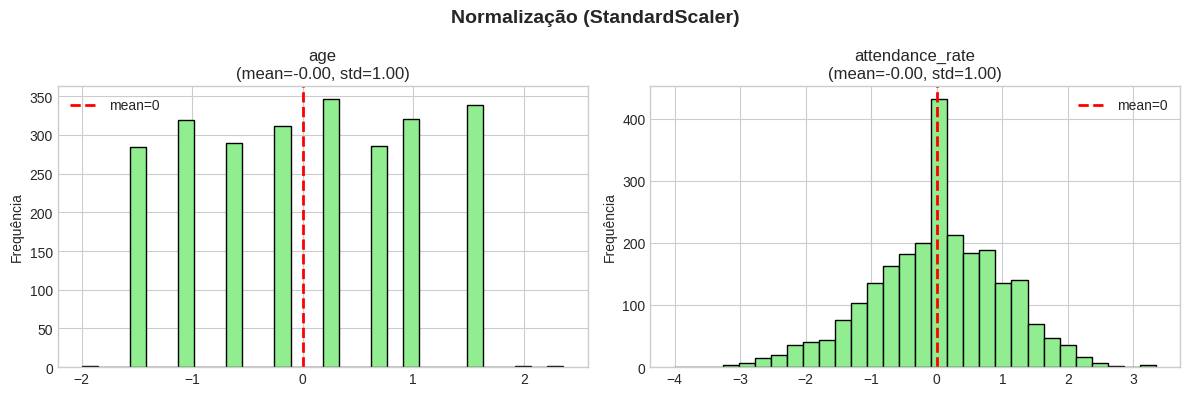

In [25]:
# VISUALIZAÇÃO 5: Distribuições normalizadas

if len(features_to_scale) >= 2:
    sample_features = features_to_scale[:2]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    for idx, feat in enumerate(sample_features):
        axes[idx].hist(df[feat].dropna(), bins=30, color='lightgreen', edgecolor='black')
        axes[idx].set_title(f'{feat}\n(mean={df[feat].mean():.2f}, std={df[feat].std():.2f})')
        axes[idx].set_ylabel('Frequência')
        axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='mean=0')
        axes[idx].legend()

    plt.suptitle('Normalização (StandardScaler)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 📝 RESPOSTAS - PARTE 7

**Q14. Quantas features você escalou?**

Resposta:
```
Features escaladas: X

Excluídas:
- final_grade (target)
- Variáveis binárias (0/1)
```

**Q15. Por que salvar o scaler?**

Resposta:
```
CRÍTICO para produção!

Quando novos dados chegarem, devemos transformá-los com as
MESMAS estatísticas (média e desvio padrão) do treino.

Código futuro:
scaler = joblib.load('scaler.pkl')
X_novo_scaled = scaler.transform(X_novo)
```

---
## 💾 SALVAMENTO FINAL

In [26]:
# IMPORTANTE: Verificação final de missing values
print("="*60)
print("VERIFICAÇÃO FINAL DE QUALIDADE")
print("="*60)

missing_final = df.isnull().sum().sum()
print(f"\n📊 Missing values antes da limpeza: {missing_final}")

if missing_final > 0:
    print(f"\n⚠️  ATENÇÃO: {missing_final} missing values detectados!")
    missing_cols = df.isnull().sum()
    missing_cols = missing_cols[missing_cols > 0]
    print("\nColunas com missing:")
    for col, count in missing_cols.items():
        print(f"  - {col}: {count}")
    
    print(f"\n🔧 Aplicando limpeza final (dropna)...")
    rows_before = len(df)
    df = df.dropna()
    rows_after = len(df)
    print(f"   Linhas removidas: {rows_before - rows_after}")
    print(f"   ✅ Dataset 100% limpo: {df.isnull().sum().sum()} missing")
else:
    print("   ✅ Nenhum missing value detectado!")

# Salvar dataset limpo
os.makedirs('../data', exist_ok=True)
df.to_csv('../data/students_clean.csv', index=False)

print("\n" + "="*60)
print("✅ ETAPA 2 CONCLUÍDA!")
print("="*60)
print(f"\n📊 Dataset final:")
print(f"   Registros: {len(df)}")
print(f"   Features: {df.shape[1]}")
print(f"   Missing: {df.isnull().sum().sum()} ✅")
print(f"\n📁 Arquivos gerados:")
print(f"   ✅ ../data/students_clean.csv (100% limpo!)")
print(f"   ✅ ../models/scaler.pkl")
print(f"\n🚀 Próximo: Etapa 3 - Modelagem")
print("="*60)

VERIFICAÇÃO FINAL DE QUALIDADE

📊 Missing values antes da limpeza: 9

⚠️  ATENÇÃO: 9 missing values detectados!

Colunas com missing:
  - study_hours_week_log: 3
  - study_sleep_ratio: 3
  - engagement: 3

🔧 Aplicando limpeza final (dropna)...
   Linhas removidas: 3
   ✅ Dataset 100% limpo: 0 missing

✅ ETAPA 2 CONCLUÍDA!

📊 Dataset final:
   Registros: 2495
   Features: 23
   Missing: 0 ✅

📁 Arquivos gerados:
   ✅ ../data/students_clean.csv (100% limpo!)
   ✅ ../models/scaler.pkl

🚀 Próximo: Etapa 3 - Modelagem


In [27]:
# Preview final
print("\n👀 Preview do dataset limpo:")
print(df.head())

print("\nℹ️  Info do dataset:")
print(df.info())


👀 Preview do dataset limpo:
  student_id       age  attendance_rate  previous_scores  final_grade  \
0   STD01416  0.179822         1.043820        -0.849125        85.39   
1   STD01345 -1.127246        -0.067653        -0.753881        98.43   
2   STD01705  1.486890         0.025574         1.556852       100.00   
3   STD00299 -0.255867         0.917445        -0.684613        86.85   
4   STD01762 -1.127246        -0.935700        -0.352344        83.25   

   study_hours_week_log  sleep_hours_sqrt  gender_Female  gender_M  \
0             -0.767543         -0.359476              0         1   
1              0.658010          0.899816              0         1   
2              0.240090         -0.269834              0         1   
3             -1.340056          0.042116              0         0   
4             -1.214902          0.855837              0         0   

   gender_Male  ...  extracurricular_Yes  tutoring_Yes  internet_quality_Good  \
0            0  ...           

In [28]:
missing_count = df.isnull().sum().sum()
missing_count

np.int64(0)

---
## ✅ CHECKLIST FINAL

Antes de entregar, verifique:

- [ ] **15 questões respondidas** (Q1-Q15)
- [ ] **5 visualizações criadas**
- [ ] Dataset limpo salvo (`students_clean.csv`)
- [ ] Scaler salvo (`models/scaler.pkl`)
- [ ] Notebook executa sem erros (**Restart & Run All**)
- [ ] Código documentado com markdown
- [ ] Commit no GitHub com mensagem descritiva

**Próximo passo:** Etapa 3 - Modelos de Machine Learning

**Parabéns! Etapa 2 completa!** 🎉